In [508]:
import numpy as np
import time
import copy
import math
import random
import itertools

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

In [556]:
# Auxiliary Functions
def polynomial_kernel(train_dat, test_pt, p):
    """
    Computes the polynomial kernel for a given order
    Input:
    train_dat = m x dim array
    test_pt = n x dim vector
    p = polynomial order, scalar
    
    Output:
    result = m x n array, where result[i,j] = K(x_train[i,:], test_pt[j,:])
    
    Note: To allow bulk evaluation for efficiency
    """
    return ((train_dat @ test_pt.T)**p)

def gaussian_kernel(train_dat, test_pt, c):
    """
    Computes the gaussian kernel for a given c
    """
    
    Sxx = np.sum(train_dat * train_dat, axis = 1).reshape(-1,1)
    Syy = np.sum(test_pt * test_pt, axis = 1).reshape(1,-1)
    Sxy = train_dat @ test_pt.T
    
    distances_train_test = Sxx + Syy - 2 * Sxy
    
    return np.exp(-c * distances_train_test)

def pick_second_point(i1, error_cache, alphas, progress, m):
    """
    Picks second point for SMO. Depending on progress, either pick the point randomly, or follow
    the heuristic on the SMO original paper
    """
#     E1 = error_cache[i1]; temp_cache = copy.deepcopy(error_cache)
    
    # Find non-bound alphas
#     non_bound_alphas = np.logical_and(alphas != 0, alphas != C)
    
    # Get error cache of all non-bound alphas only. If E1 is positive, we want to pick the most negative E2, hence set all 
    # non bounds to inf. Else, pick most positive E2, hence set all to be -inf
#     temp_cache[np.logical_not(non_bound_alphas)] = (2 * (E1 >= 0) - 1) * np.inf
    
    # Count number of non-bounds
#     non_bound_count = np.sum(non_bound_alphas)
    non_bound_count = -5
    
    
    if progress == -1 and non_bound_count > 1:
        # i.e. first attempt, so pick according to heuristic
        if E1 > 0:
            # Look for most negative that is not i1
            min1, min2 = np.argsort(temp_cache)[:2]
            
            # if the minimum is E1, then take the second minimum
            if min1 == i1:
                i2 = min2
            else:
                i2 = min1
                
        else:
            # Look for most positive E2, that is not i1
            max1, max2 = np.argsort(temp_cache)[-2:]
            if max2 == i1:
                i2 = max1
            else:
                i2 = max2
    else: # either picking by heuristic => no progress, or no valid heuristic point. Hence pick randomly
        i2 = np.random.choice(m)
        while i2 == i1:
            i2 = np.random.choice(m)
            
    return i2

def split_train_test(data_samples, data_labels, train_prop, test_prop, seed = 88):
    """
    Split to 80% train and 20% test as required, randomly by first shuffling
    """
    n_tot = data_samples.shape[0]; n_train = round(train_prop * n_tot)
    
    np.random.seed(seed)
    permute = np.random.permutation(n_tot)
    
    data_shuffled = data_samples[permute,:]
    data_shuffled_labels = data_labels[permute]
    
    train_samples = data_shuffled[:n_train, :]; train_labels = data_shuffled_labels[:n_train]
    test_samples = data_shuffled[n_train:, :]; test_labels = data_shuffled_labels[n_train:]
    
    return train_samples, train_labels, test_samples, test_labels

In [538]:
def SMO(data, labels, C, kernel_mat):
    """
    Solves for lagrange multipliers of SVM problem given the training data, and {1, -1} labels
    
    Note: A simplified version of the original SMO is used here. Refer to 
    
    Returns:
    vector length m of alphas (lagrange multipliers) and the bias term b
    """
    # Initialisations
    m = data.shape[0]
    tolerance = 10e-0100 # numerical tolerance, i.e. for something to be treated as equal to something
    tol_kkt = 10e-02
    
    max_iter = 10 # maximum number of passes through WHOLE dataset, to pick first point. This is to speed up training
    # while maintaining a relatively good performance
    
    alphas = np.zeros((m))
    bias = 0; error_cache = -labels; 
    second_prog = 5
    
    passes = 0; it = 0
    
    while it < max_iter and passes < 500:
        # SMO starts here
        alphas_changed = 0 # to debug if there's progress
        
        # Iterate through whole dataset to pick the first alpha
        for i in range(m):
            prog_second_pt = 0
            
            # Update error cache for the first alpha. Only update for the picked alphas, to save computation
            error_cache[i] = (alphas * labels) @ kernel_mat[:, i] + bias - labels[i]
            
            # Check if first point violates KKT. By Osuna's theorem, we only need to take at least one 
            # alpha whose corresponding training point violates KKT.
            
            # See report for mathematical derivation. Margin_m1 = y*y_hat - 1
            margin_m1 = error_cache[i] * labels[i]
            
            if (margin_m1 < -tol_kkt and alphas[i] < C) or (margin_m1 > tol_kkt and alphas[i] > 0):
                # Hence KKT violated for this point. We now pick 2nd point
                
                while prog_second_pt < second_prog:
                    # We allow 5 trials in picking 2nd point. If all 5 don't have progress, move on to the next
                    # FIRST point.
                    
                    j = pick_second_point(i, error_cache, alphas, prog_second_pt, m)
                    
                    # Once picked, we re-evaluate the error cache for this potential point. In case the corresponding alpha has changed
                    # from previous iteration. I.e. we compute the errors minimally, only when we need it
                    error_cache[j] = (alphas * labels) @ kernel_mat[:, j] + bias - labels[j]
                    
                    # Compute lower and upper bounds.
                    if labels[i] == labels[j]:
                        L = max(0, alphas[i] + alphas[j] - C)
                        H = min(C, alphas[i] + alphas[j])
                    else:
                        L = max(0, alphas[j] - alphas[i])
                        H = min(C, C + alphas[j] - alphas[i])
                        
                    if L == H: # unusual case, not a good update
                        prog_second_pt += 1
                        continue # pick next second point
                        
                    # Compute eta by the paper's equation
                    eta = 2 * kernel_mat[i,j] - kernel_mat[i,i] - kernel_mat[j,j]
                    
                    # Unusual condition on eta
                    if eta >= 0:
                        prog_second_pt += 1
                        continue
                        
                    
                    # Compute new alpha2
                    a2 = alphas[j] - (labels[j] * (error_cache[i] - error_cache[j]) / eta)
                    
                    # Bound it
                    if a2 > H:
                        a2 = H
                    elif a2 < L:
                        a2 = L
                    
                    # See if this makes significant progress compared to current alpha2
                    if abs(alphas[j] - a2) < tolerance:
                        # No progress, essentially a2 = alphas[j]
                        prog_second_pt += 1
                        continue
                    
                    # Otherwise, there is progress. We can compute new alpha1, and update them
                    a1 = alphas[i] + labels[i] * labels[j] * (alphas[j] - a2)
                    
                    # Compute new bias
                    b1 = bias - error_cache[i] - labels[i] * (a1 - alphas[i]) * kernel_mat[i, i] - labels[j] * (a2 - alphas[j]) * kernel_mat[i, j]
                    b2 = bias - error_cache[j] - labels[i] * (a1 - alphas[i]) * kernel_mat[i, j] - labels[j] * (a2 - alphas[j]) * kernel_mat[j, j]
                    
                    if (a1 > 0) and (a1 < C): # if new alpha1 is valid, then b = b1
                        bias = b1
                    elif (a2 > 0) and (a2 < C): # if new alpha2 is valid, then b = b2
                        bias = b2
                    else:
                        bias = (b1 + b2) / 2
                        
                    # Then update alphas
                    alphas[i] = a1; alphas[j] = a2
                    
                    alphas_changed += 1
                    
                    prog_second_pt = 10000 # To break us out of the while no progress loop for second point, and move on to next first point
                    
        # By end of one pass through data point check if there's any alphas changed
        if alphas_changed >= 1:
            passes = 0
        else:
#             print("No alphas changed")
            passes += 1
            
        it += 1
        
        
    return alphas, bias, error_cache

def fit_ovo_SVM(data, labels, C, num_classes, d):
    """
    returns num_combinations of svm's alphas and biases
    """
    
    # Get all possible 'versus'
    indic_mat = np.array([list(choice) for choice in itertools.combinations(np.arange(num_classes), 2)])
    
    # initialise empty arrays for alphas and biases
    all_alphas = []; all_biases = []
    
    start_ovo = time.time()
    for label1, label2 in indic_mat:
        start_svm = time.time()
        # iterate through all versuses, fit svm
        
        # get the data corresponding to those labels
        index1 = (labels == label1); index2 = (labels == label2); indexes = np.logical_or(index1, index2)
        copy_labels = copy.deepcopy(labels)
        
        # label1 is positive class, label2 is negative class
        copy_labels[index1] = 1; copy_labels[index2] = -1
        
        # get the data and labels
        train_samples = data[indexes, :]; train_labels = copy_labels[indexes]
        
        # fit SVM
        kernel_train = polynomial_kernel(train_samples, train_samples, d)
        alphas, bias, _ = SMO(train_samples, train_labels, C, kernel_train)
        
        # for debugging; predict to see if the fitted alphas are good
        preds = np.sign((alphas * train_labels).reshape(1,-1) @ kernel_train + bias).reshape(-1)
        
#         print(f"For {label1} vs {label2}, error rate is {np.mean(preds != train_labels)}")
        
        # store results
        all_alphas.append(alphas); all_biases.append(bias)
        
#         print(f"For {label1} vs {label2}, done in {time.time() - start_svm}")
        
    print(f"All done in {time.time() - start_ovo}")
    
    return all_alphas, all_biases

def pred_class(pred_arg, indic_mat):
    """
    given an un-normalised prediction vector, give the final class prediction (i.e. integer label)
    """
    # By convention, 0 is negative, althought 0 would generally not happen in perceptron
    which_class = 1* (pred_arg <= 0) # hence all positive predictions are now 0, all negative arguments are 1
    classifier_preds = indic_mat[np.arange(indic_mat.shape[0]), which_class] # for each classifier, if positive, grab the left class in the indic matrix, else grab the right class
    
    # Count class votes
    unique, counts = np.unique(classifier_preds, return_counts = True)
    
    # Prediction is just maximum counted class
    pred_lab = unique[np.argmax(counts)]
    
    return pred_lab

def predictOvO(all_train_samples, all_train_labels, test_samples, test_labels, all_alphas, all_biases, d):
        """
        Predict final label using num_classes choose 2 classifers
        """
        # Compute all test, then slice from here
        kernel_test = polynomial_kernel(all_train_samples, test_samples, d)
        
        indic_mat = np.array([list(choice) for choice in itertools.combinations(np.arange(num_classes), 2)])
        num_classifier = indic_mat.shape[0]; n_test = test_samples.shape[0]
        test_predictions_ovo = np.zeros((n_test, num_classifier))
        
        for i in range(num_classifier):
            
            label1, label2 = indic_mat[i]
            alpha = all_alphas[i]; bias = all_biases[i]
            
            # Get the relevant training sample indexes
            index1 = (all_train_labels == label1); index2 = (all_train_labels == label2); indexes = np.logical_or(index1, index2)
            copy_labels = copy.deepcopy(all_train_labels)
            copy_labels[index1] = 1; copy_labels[index2] = -1
            
            # Slice the relevant test kernel, and also the labels
            rel_kernel_test = kernel_test[indexes, :]
            rel_labels = copy_labels[indexes]
            
            # Predict
            pred_vect = (alpha * rel_labels).reshape(1, -1) @ rel_kernel_test + bias
            
            # Store
            test_predictions_ovo[:, i] = pred_vect.reshape(-1)
            
        # Have all vectorised predictions converted to labels
        pred_labels = []
        for i in range(test_predictions_ovo.shape[0]):
            pred_labels.append(pred_class(test_predictions_ovo[i,:], indic_mat))
            
        pred_labels = np.array(pred_labels)
        mistakes = pred_labels != test_labels
        
        return np.mean(mistakes), pred_labels
    
def predictOvOGauss(all_train_samples, all_train_labels, test_samples, test_labels, all_alphas, all_biases, c):
        """
        Predict final label using num_classes choose 2 classifers
        """
        # Compute all test, then slice from here
        kernel_test = gaussian_kernel(all_train_samples, test_samples, c)
        
        indic_mat = np.array([list(choice) for choice in itertools.combinations(np.arange(num_classes), 2)])
        num_classifier = indic_mat.shape[0]; n_test = test_samples.shape[0]
        test_predictions_ovo = np.zeros((n_test, num_classifier))
        
        for i in range(num_classifier):
            
            label1, label2 = indic_mat[i]
            alpha = all_alphas[i]; bias = all_biases[i]
            
            # Get the relevant training sample indexes
            index1 = (all_train_labels == label1); index2 = (all_train_labels == label2); indexes = np.logical_or(index1, index2)
            copy_labels = copy.deepcopy(all_train_labels)
            copy_labels[index1] = 1; copy_labels[index2] = -1
            
            # Slice the relevant test kernel, and also the labels
            rel_kernel_test = kernel_test[indexes, :]
            rel_labels = copy_labels[indexes]
            
            # Predict
            pred_vect = (alpha * rel_labels).reshape(1, -1) @ rel_kernel_test + bias
            
            # Store
            test_predictions_ovo[:, i] = pred_vect.reshape(-1)
            
        # Have all vectorised predictions converted to labels
        pred_labels = []
        for i in range(test_predictions_ovo.shape[0]):
            pred_labels.append(pred_class(test_predictions_ovo[i,:], indic_mat))
            
        pred_labels = np.array(pred_labels)
        mistakes = pred_labels != test_labels
        
        return np.mean(mistakes), pred_labels
    
def fit_ovo_SVM_gauss(data, labels, C, num_classes, c):
    """
    returns num_combinations of svm's alphas and biases
    """
    
    # Get all possible 'versus'
    indic_mat = np.array([list(choice) for choice in itertools.combinations(np.arange(num_classes), 2)])
    
    # initialise empty arrays for alphas and biases
    all_alphas = []; all_biases = []
    
    start_ovo = time.time()
    for label1, label2 in indic_mat:
        start_svm = time.time()
        # iterate through all versuses, fit svm
        
        # get the data corresponding to those labels
        index1 = (labels == label1); index2 = (labels == label2); indexes = np.logical_or(index1, index2)
        copy_labels = copy.deepcopy(labels)
        
        # label1 is positive class, label2 is negative class
        copy_labels[index1] = 1; copy_labels[index2] = -1
        
        # get the data and labels
        train_samples = data[indexes, :]; train_labels = copy_labels[indexes]
        
        # fit SVM
        kernel_train = gaussian_kernel(train_samples, train_samples, c)
        alphas, bias, _ = SMO(train_samples, train_labels, C, kernel_train)
        
        # for debugging; predict to see if the fitted alphas are good
        preds = np.sign((alphas * train_labels).reshape(1,-1) @ kernel_train + bias).reshape(-1)
        
#         print(f"For {label1} vs {label2}, error rate is {np.mean(preds != train_labels)}")
        
        # store results
        all_alphas.append(alphas); all_biases.append(bias)
        
#         print(f"For {label1} vs {label2}, done in {time.time() - start_svm}")
        
    print(f"All done in {time.time() - start_ovo}")
    
    return all_alphas, all_biases
            
    
            
        
    
    
    

In [355]:
# Load full data
path_real_data = "./zipcombo.dat"
data = np.loadtxt(path_real_data)
data_samples = data[:, 1:]; data_labels = data[:, 0].astype(int)

## Polynomial Kernel

### 1) Basic Run

In [752]:
# Trial template to experiment with different values of hyperparameter, to find reasonable values to explore
train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = 8)
d = 1; C = 1e-20
all_alphas, all_biases = fit_ovo_SVM(train_samples, train_labels, C, num_classes, d)
train_rate, train_preds = predictOvO(train_samples, train_labels, train_samples, train_labels, all_alphas, all_biases, d)
test_rate, test_preds = predictOvO(train_samples, train_labels, test_samples, test_labels, all_alphas, all_biases, d)

print(train_rate, test_rate)

All done in 15.2005774974823
0.3465985479967733 0.3403225806451613


In [707]:
Cs = [1 * 1e-30, 1 * 1e-12, 1]
# Cs = [1, 1e30]
d_range = 1 + np.arange(7)
num_classes = 10
num_iter = 20
results_train = np.zeros((len(d_range), len(Cs),num_iter)); results_test = np.zeros((len(d_range), len(Cs),num_iter))

start = time.time()
for it in range(num_iter):
    # For each iteration re-split. But NOT re-split for every d, lest it won't be a fair comparison
    start_iter = time.time()
    train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = it)
    print(f"Iteration {it+1}/{num_iter}")
    
    # Iterate through hyperparameters
    start_iter = time.time()
    for c_ind in range(len(Cs)):
        C = Cs[c_ind]; start_d = time.time()
        for d in d_range:
            # Train svm, then predict on train and test
            all_alphas, all_biases = fit_ovo_SVM(train_samples, train_labels, C, num_classes, d)
            
            # Predict
            train_rate, train_preds = predictOvO(train_samples, train_labels, train_samples, train_labels, all_alphas, all_biases, d)
            test_rate, test_preds = predictOvO(train_samples, train_labels, test_samples, test_labels, all_alphas, all_biases, d)
            
            print(f"For d = {d}, C = {C}, train rate is {train_rate}, and test rate is {test_rate}")
            
            # Append results
            results_train[d-1, c_ind, it] = train_rate; results_test[d-1, c_ind, it] = test_rate
            
        print(f"All d's done in {time.time() - start_d}")
    
    print(f"Iteration done in {time.time() - start_iter}")
    
print(f"{num_iter} iterations done in {time.time() - start}")

Iteration 1/20
All done in 30.046650171279907
For d = 1, C = 1e-30, train rate is 0.3734874966388814, and test rate is 0.37311827956989246
All done in 29.799429416656494
For d = 2, C = 1e-30, train rate is 0.3334229631621404, and test rate is 0.3349462365591398
All done in 32.35429906845093
For d = 3, C = 1e-30, train rate is 0.3041140091422425, and test rate is 0.3016129032258065
All done in 31.701435565948486
For d = 4, C = 1e-30, train rate is 0.2787039526754504, and test rate is 0.27741935483870966
All done in 27.39298701286316
For d = 5, C = 1e-30, train rate is 0.5379134175853724, and test rate is 0.5268817204301075
All done in 14.465345859527588
For d = 6, C = 1e-30, train rate is 0.09559021242269428, and test rate is 0.12903225806451613
All done in 16.764564037322998
For d = 7, C = 1e-30, train rate is 0.39593976875504167, and test rate is 0.4204301075268817
All d's done in 207.16390562057495
All done in 12.07235336303711
For d = 1, C = 1e-12, train rate is 0.22909384243076095,

All done in 29.2289137840271
For d = 1, C = 1e-30, train rate is 0.375369723043829, and test rate is 0.36451612903225805
All done in 30.671324014663696
For d = 2, C = 1e-30, train rate is 0.33476741059424575, and test rate is 0.33064516129032256
All done in 31.741820573806763
For d = 3, C = 1e-30, train rate is 0.3050551223447163, and test rate is 0.3016129032258065
All done in 31.858186721801758
For d = 4, C = 1e-30, train rate is 0.27695617101371334, and test rate is 0.2731182795698925
All done in 27.392918348312378
For d = 5, C = 1e-30, train rate is 0.5385856413014252, and test rate is 0.5467741935483871
All done in 14.66572117805481
For d = 6, C = 1e-30, train rate is 0.11199247109438021, and test rate is 0.12903225806451613
All done in 15.945512294769287
For d = 7, C = 1e-30, train rate is 0.3625974724388276, and test rate is 0.3790322580645161
All d's done in 206.27717185020447
All done in 11.798530340194702
For d = 1, C = 1e-12, train rate is 0.21968271040602314, and test rate 

All done in 28.961852073669434
For d = 1, C = 1e-30, train rate is 0.37093304651788117, and test rate is 0.37849462365591396
All done in 30.640109539031982
For d = 2, C = 1e-30, train rate is 0.33476741059424575, and test rate is 0.3456989247311828
All done in 32.39600610733032
For d = 3, C = 1e-30, train rate is 0.3041140091422425, and test rate is 0.31989247311827956
All done in 31.876234769821167
For d = 4, C = 1e-30, train rate is 0.27735950524334496, and test rate is 0.2913978494623656
All done in 26.606645822525024
For d = 5, C = 1e-30, train rate is 0.49744554987899975, and test rate is 0.5150537634408602
All done in 14.22600793838501
For d = 6, C = 1e-30, train rate is 0.098010217800484, and test rate is 0.1338709677419355
All done in 15.79692816734314
For d = 7, C = 1e-30, train rate is 0.3615219144931433, and test rate is 0.4010752688172043
All d's done in 205.1428201198578
All done in 11.604981899261475
For d = 1, C = 1e-12, train rate is 0.2249260553912342, and test rate is

All done in 30.78037166595459
For d = 1, C = 1e-30, train rate is 0.375369723043829, and test rate is 0.3704301075268817
All done in 31.101945400238037
For d = 2, C = 1e-30, train rate is 0.33584296853993006, and test rate is 0.3349462365591398
All done in 34.37273144721985
For d = 3, C = 1e-30, train rate is 0.303979564399032, and test rate is 0.3016129032258065
All done in 33.16091227531433
For d = 4, C = 1e-30, train rate is 0.27493949986555527, and test rate is 0.27419354838709675
All done in 27.78865694999695
For d = 5, C = 1e-30, train rate is 0.5492067760150579, and test rate is 0.5661290322580645
All done in 14.601682901382446
For d = 6, C = 1e-30, train rate is 0.08819575154611455, and test rate is 0.12096774193548387
All done in 16.537631034851074
For d = 7, C = 1e-30, train rate is 0.3526485614412476, and test rate is 0.38763440860215054
All d's done in 214.0711908340454
All done in 11.963194608688354
For d = 1, C = 1e-12, train rate is 0.22734606076902394, and test rate is 

All done in 29.809441089630127
For d = 1, C = 1e-30, train rate is 0.3734874966388814, and test rate is 0.3720430107526882
All done in 30.027312994003296
For d = 2, C = 1e-30, train rate is 0.33638074751277225, and test rate is 0.33225806451612905
All done in 32.13282537460327
For d = 3, C = 1e-30, train rate is 0.3090884646410325, and test rate is 0.30376344086021506
All done in 32.46431255340576
For d = 4, C = 1e-30, train rate is 0.27897284216187146, and test rate is 0.2801075268817204
All done in 26.78266739845276
For d = 5, C = 1e-30, train rate is 0.5309222909384244, and test rate is 0.5403225806451613
All done in 14.503252267837524
For d = 6, C = 1e-30, train rate is 0.10217800484001076, and test rate is 0.12473118279569892
All done in 16.095017910003662
For d = 7, C = 1e-30, train rate is 0.2727883839741866, and test rate is 0.30752688172043013
All d's done in 206.5409858226776
All done in 11.929758787155151
For d = 1, C = 1e-12, train rate is 0.2212960473245496, and test rate 

All done in 29.337796449661255
For d = 1, C = 1e-30, train rate is 0.377117504705566, and test rate is 0.36989247311827955
All done in 29.64034914970398
For d = 2, C = 1e-30, train rate is 0.3375907502016671, and test rate is 0.3317204301075269
All done in 31.858972787857056
For d = 3, C = 1e-30, train rate is 0.3085506856681904, and test rate is 0.2946236559139785
All done in 32.0077018737793
For d = 4, C = 1e-30, train rate is 0.2803172895939769, and test rate is 0.26666666666666666
All done in 27.09882616996765
For d = 5, C = 1e-30, train rate is 0.47230438289862864, and test rate is 0.4817204301075269
All done in 14.428647518157959
For d = 6, C = 1e-30, train rate is 0.09545576767948373, and test rate is 0.11666666666666667
All done in 16.249599933624268
For d = 7, C = 1e-30, train rate is 0.3003495563323474, and test rate is 0.3231182795698925
All d's done in 205.27937006950378
All done in 11.885310649871826
For d = 1, C = 1e-12, train rate is 0.22842161871470826, and test rate is

All done in 29.58003330230713
For d = 1, C = 1e-30, train rate is 0.37429416509814467, and test rate is 0.3811827956989247
All done in 29.490396976470947
For d = 2, C = 1e-30, train rate is 0.33503630008066687, and test rate is 0.3349462365591398
All done in 31.81925106048584
For d = 3, C = 1e-30, train rate is 0.30613068029040064, and test rate is 0.31344086021505374
All done in 32.49436068534851
For d = 4, C = 1e-30, train rate is 0.2731917182038182, and test rate is 0.278494623655914
All done in 29.66985583305359
For d = 5, C = 1e-30, train rate is 0.5825490723312718, and test rate is 0.5887096774193549
All done in 14.834704160690308
For d = 6, C = 1e-30, train rate is 0.09585910190911535, and test rate is 0.12150537634408602
All done in 16.6595401763916
For d = 7, C = 1e-30, train rate is 0.32912073137940306, and test rate is 0.32204301075268815
All d's done in 210.10684657096863
All done in 12.120007514953613
For d = 1, C = 1e-12, train rate is 0.22411938693197095, and test rate i

In [708]:
# Prints
res_train_mean = np.mean(results_train, axis = -1); res_test_mean = np.mean(results_test, axis = -1)
res_train_std = np.std(results_train, axis = -1); res_test_std = np.std(results_test, axis = -1)
for ls_idx in range(res_train_mean.shape[0]):
    for fs_idx in range(res_train_mean.shape[1]):
        d = d_range[ls_idx]; C = Cs[fs_idx]
        print(f"For Polynomial Degree of {d} and C of {C}, average training error is {res_train_mean[ls_idx, fs_idx]} with std of {res_train_std[ls_idx, fs_idx]}")
        print(f"For Polynomial Degree of {d} and C of {C}, average test error is {res_test_mean[ls_idx, fs_idx]} with std of {res_test_std[ls_idx, fs_idx]}")

For Polynomial Degree of 1 and C of 1e-30, average training error is 0.3731110513578919 with std of 0.0030877248371221537
For Polynomial Degree of 1 and C of 1e-30, average test error is 0.37502688172043 with std of 0.010860314861672745
For Polynomial Degree of 1 and C of 1e-12, average training error is 0.22547055660123688 with std of 0.005797901298004903
For Polynomial Degree of 1 and C of 1e-12, average test error is 0.23526881720430107 with std of 0.0084245785028469
For Polynomial Degree of 1 and C of 1, average training error is 0.037738639419198715 with std of 0.008188347124113711
For Polynomial Degree of 1 and C of 1, average test error is 0.06373655913978495 with std of 0.007887804059732124
For Polynomial Degree of 2 and C of 1e-30, average training error is 0.3348749663888142 with std of 0.0033209756605814943
For Polynomial Degree of 2 and C of 1e-30, average test error is 0.33819892473118285 with std of 0.009275518060319678
For Polynomial Degree of 2 and C of 1e-12, average t

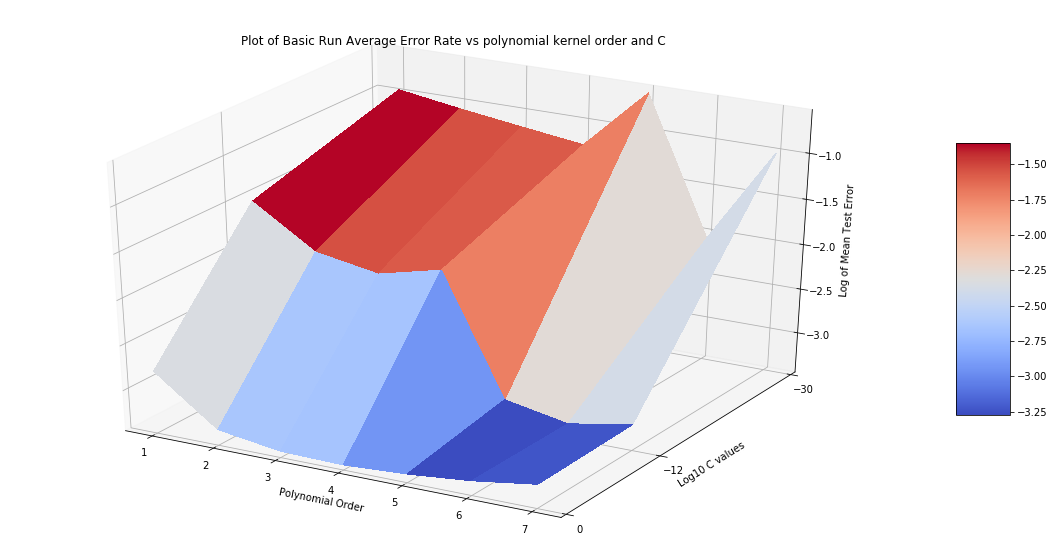

In [710]:
# Plot 
C_pow = np.log10(np.array(Cs));

# Test Results
d_grid, C_powgrid = np.meshgrid(d_range,C_pow)
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
# ax.set_zlim(0, 30)
ax.set_xlabel("Polynomial Order")
ax.set_yticks(C_pow)
ax.set_ylim(0,-30)
ax.set_ylabel("Log10 C values")
ax.set_zlabel("Log of Mean Test Error")
ax.set_title("Plot of Basic Run Average Error Rate vs polynomial kernel order and C")
MSE_surf = ax.plot_surface(d_grid, C_powgrid, np.log(res_test_mean.T), cmap = cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(MSE_surf, shrink=0.5, aspect=5)

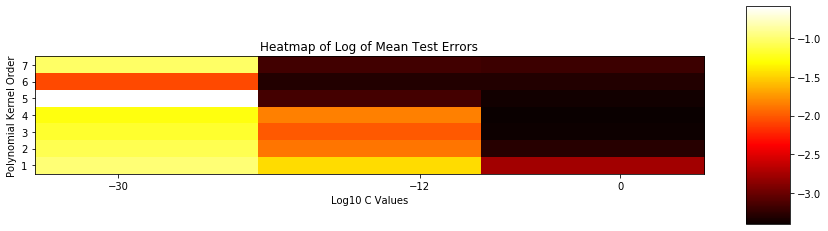

In [711]:
# Test Heatmap
fig = plt.figure(figsize = (15,8))
heat_map = plt.imshow(np.log(res_test_mean), cmap="hot", origin="lower", 
           extent=[C_pow[0] - 5, C_pow[-1] + 5, d_range[0]-0.5, d_range[-1] + 0.5])
plt.xlabel("Log10 C Values")
plt.xticks(C_pow)
plt.yticks(d_range)
plt.ylabel("Polynomial Kernel Order")
plt.title("Heatmap of Log of Mean Test Errors")
fig.colorbar(heat_map, shrink=0.5, aspect=5)

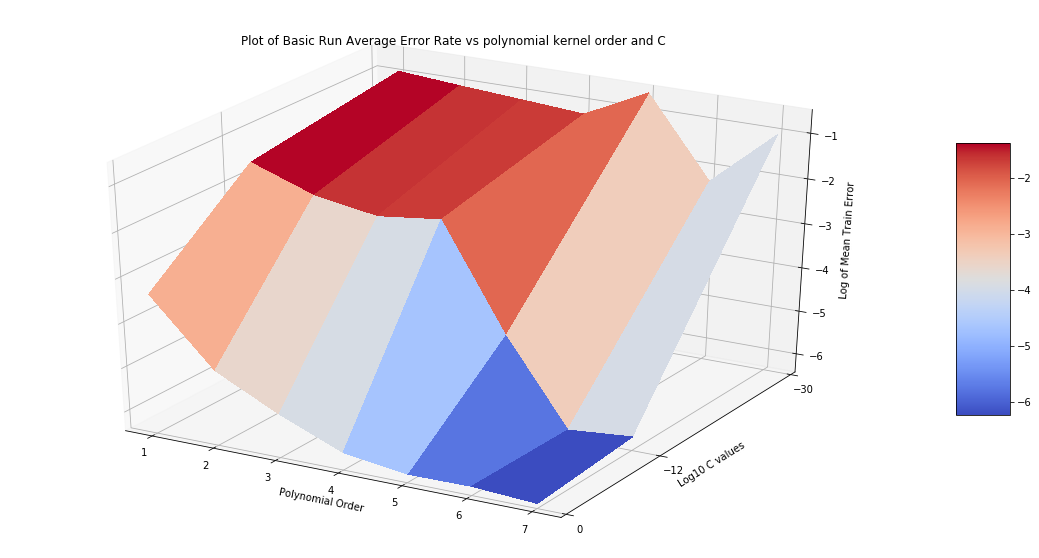

In [714]:
# Train Results
d_grid, C_powgrid = np.meshgrid(d_range,C_pow)
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
# ax.set_zlim(0, 30)
ax.set_xlabel("Polynomial Order")
ax.set_yticks(C_pow)
ax.set_ylim(0,-30)
ax.set_ylabel("Log10 C values")
ax.set_zlabel("Log of Mean Train Error")
ax.set_title("Plot of Basic Run Average Error Rate vs polynomial kernel order and C")
MSE_surf = ax.plot_surface(d_grid, C_powgrid, np.log(res_train_mean.T), cmap = cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(MSE_surf, shrink=0.5, aspect=5)

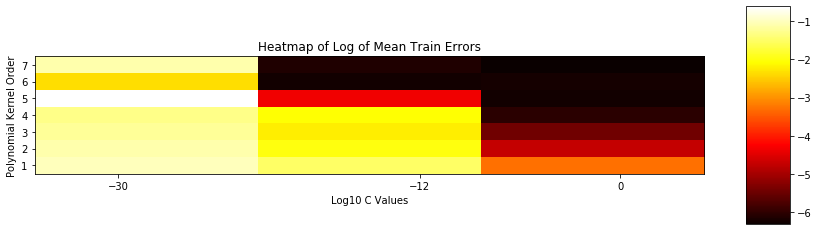

In [713]:
# Train Heatmap
fig = plt.figure(figsize = (15,8))
heat_map = plt.imshow(np.log(res_train_mean), cmap="hot", origin="lower", 
           extent=[C_pow[0] - 5, C_pow[-1] + 5, d_range[0]-0.5, d_range[-1] + 0.5])
plt.xlabel("Log10 C Values")
plt.xticks(C_pow)
plt.yticks(d_range)
plt.ylabel("Polynomial Kernel Order")
plt.title("Heatmap of Log of Mean Train Errors")
fig.colorbar(heat_map, shrink=0.5, aspect=5)

### 2) Cross Validation

In [519]:
# Auxiliary Functions
def getSubArray(x_train, y_train,n, seed = None):
    """
    Divide the training set into n sub-arrays
    
    Inputs:
    x_train,y train: m x n and m x 1 respectively. 
    n: # of sub-arrays
    """
    res_x = []; res_y = []; sub_arr_indexes = []
    n_samples = x_train.shape[0]; inc = n_samples/n;
    
    # Set seed to get repeatable results
    if seed is not None:
        random.seed(seed)
    
    # Not needed to shuffle because already shuffled before splitting to train and test
    # shuffle the training data before splitting to sub-arrays
#     permute = random.sample(range(n_samples), n_samples)
#     x_train = x_train[permute,:]
#     y_train = y_train[permute,:]
    
    # divide into sub-arrays
    start_idx = 0; end_idx = 0
    for _ in range(n):
        end_idx += inc
        round_end = math.floor(end_idx)
        sub_arr_indexes.append((start_idx, round_end))
        res_x.append(x_train[start_idx:round_end,:])
        res_y.append(y_train[start_idx:round_end,:])
        start_idx = round_end
    
    return res_x, res_y, sub_arr_indexes

def catSubArrays(folds):
    """
    Function to concatenate multiple sub-arrays to a single m x n array
    Input:
    folds: a list of 2d arrays to concatenate
    """
    res = folds[0]
    for idx in range(1,len(folds)):
        res = np.concatenate([res,folds[idx]],axis = 0)
    return res

In [695]:
# Loop 20 times
pair_errors = []; best_pairs = []; # Contains 20 values, and 20 tuples of d,C
num_iter = 20
all_pair_errors = np.zeros((len(d_range), len(Cs),num_iter)) # store results of validation error of all pairs over all 20 cross validation

for it in range(num_iter):
    # Do 1 Cross Validation, and iterate 20 times
    start_val = time.time()
    n = 5;
    
    # Split for every run
    train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = it)
    
    # Divide into sub-arrays
    x_train, y_train, sub_idxs = getSubArray(train_samples, train_labels.reshape(-1,1), n)
    
    # Convert to numpy arrays for ease of slicing
    x_train = np.array(x_train); y_train = np.array(y_train)
    
    # 1 5-fold cross validation starts here
    pairs_val_results = np.zeros((len(d_range), len(Cs)))
    start_cv = time.time()
    for c_ind in range(len(Cs)):
        C = Cs[c_ind]; start_d = time.time()
        for d in d_range:
            
            # Loop through folds for a pair of hyperparameters
            val_indexes = np.arange(n); val_err = []
            start_folds = time.time()
            for val_idx in val_indexes:
                train_indexes = np.delete(val_indexes, val_idx)
                
                # Take one fold as val, rest becomes training
                val_samples = x_train[val_idx]; val_labels = y_train[val_idx].reshape(-1)
                
                # Training set
                train_mini_samples = catSubArrays(x_train[train_indexes])
                train_mini_labels = catSubArrays(y_train[train_indexes]).reshape(-1)
                
                # Train on training set, and then val
                all_alphas, all_biases = fit_ovo_SVM(train_mini_samples, train_mini_labels, C, num_classes, d)
                
                # Predict on val
                val_rate, val_preds = predictOvO(train_mini_samples, train_mini_labels, val_samples, val_labels, all_alphas, all_biases, d)
                
                # Append Results
                val_err.append(val_rate) # this is result of each/5 fold for one pair
                
            # Store this pair's results
            print(f"Time for one 5-fold over a pair is {time.time() - start_folds}")
            print(f"For d = {d} and C = {C}, val error is {np.mean(val_err)}")
            pairs_val_results[d-1, c_ind] = np.mean(np.array(val_err))
            all_pair_errors[d-1, c_ind, it] = np.mean(np.array(val_err))
            
    # After done for all hyperparameters, re-train and re-evaluate on the best combination
    print(f"Time for one 5-fold over all pairs is {time.time() - start_cv}")
    [index_d], [index_C] = np.where(pairs_val_results == np.min(pairs_val_results))
    best_d, best_C = d_range[index_d], Cs[index_C]
    
    print(f"For iteration {it+1}, best d is {best_d} and best C is {best_C}")
    
    # Re-train
    all_alphas, all_biases = fit_ovo_SVM(train_samples, train_labels, best_C, num_classes, best_d)
    
    # And predict
    test_rate, test_preds = predictOvO(train_samples, train_labels, test_samples, test_labels, all_alphas, all_biases, best_d)
    
    # Append results of this round of cross-validation
    pair_errors.append(test_rate); best_pairs.append([best_d, best_C])
    
    print(f"Time for 1 cross validation is {time.time() - start_cv}")

All done in 20.87825059890747
All done in 21.804896116256714
All done in 22.378130435943604
All done in 21.317325353622437
All done in 20.88804602622986
Time for one 5-fold over a pair is 108.86055517196655
For d = 1 and C = 1e-30, val error is 0.3756414011034702
All done in 21.12362027168274
All done in 20.763112783432007
All done in 21.3600594997406
All done in 20.98626208305359
All done in 20.61534595489502
Time for one 5-fold over a pair is 106.26757168769836
For d = 2 and C = 1e-30, val error is 0.3371909596430715
All done in 23.458575963974
All done in 23.502164125442505
All done in 23.377060890197754
All done in 23.120486736297607
All done in 22.561697244644165
Time for one 5-fold over a pair is 118.80049800872803
For d = 3 and C = 1e-30, val error is 0.3096301458518631
All done in 23.491246461868286
All done in 23.06235408782959
All done in 24.20582914352417
All done in 23.098939180374146
All done in 22.813008546829224
Time for one 5-fold over a pair is 119.50572657585144
For d

All done in 9.710194826126099
All done in 9.847375392913818
All done in 9.987412452697754
All done in 9.702026128768921
All done in 9.935819149017334
Time for one 5-fold over a pair is 52.034201860427856
For d = 4 and C = 1e-12, val error is 0.15716198089535832
All done in 9.564951419830322
All done in 9.617519617080688
All done in 9.735897779464722
All done in 9.550310611724854
All done in 9.786387920379639
Time for one 5-fold over a pair is 51.081059217453
For d = 5 and C = 1e-12, val error is 0.05055001771626498
All done in 9.96605396270752
All done in 9.601229429244995
All done in 9.866315126419067
All done in 9.671781301498413
All done in 9.795964002609253
Time for one 5-fold over a pair is 51.67030715942383
For d = 6 and C = 1e-12, val error is 0.04234946598115569
All done in 9.892812967300415
All done in 11.48410177230835
All done in 10.222992897033691
All done in 9.706994533538818
All done in 9.995942115783691
Time for one 5-fold over a pair is 54.266928911209106
For d = 7 and 

All done in 9.891594409942627
All done in 10.536306858062744
All done in 10.004769086837769
All done in 9.869356155395508
All done in 10.060666561126709
Time for one 5-fold over a pair is 53.21606254577637
For d = 7 and C = 1, val error is 0.05055101199644228
Time for one 5-fold over all pairs is 1443.7637255191803
For iteration 3, best d is 4 and best C is 1
All done in 14.782444477081299
Time for 1 cross validation is 1459.4597206115723
All done in 21.334054231643677
All done in 21.90352725982666
All done in 20.960978984832764
All done in 21.286124229431152
All done in 20.69572401046753
Time for one 5-fold over a pair is 107.63246631622314
For d = 1 and C = 1e-30, val error is 0.3777912156250226
All done in 20.298243522644043
All done in 21.261407613754272
All done in 20.5481276512146
All done in 20.740385055541992
All done in 20.068369388580322
Time for one 5-fold over a pair is 104.36458897590637
For d = 2 and C = 1e-30, val error is 0.34041604298182815
All done in 22.0522165298461

All done in 7.325420379638672
All done in 7.433963298797607
All done in 7.373294830322266
All done in 7.711996078491211
All done in 7.398227214813232
Time for one 5-fold over a pair is 38.68604278564453
For d = 2 and C = 1e-12, val error is 0.156895604196947
All done in 9.253271341323853
All done in 9.095688343048096
All done in 9.194423913955688
All done in 9.182465553283691
All done in 8.960051774978638
Time for one 5-fold over a pair is 48.37800621986389
For d = 3 and C = 1e-12, val error is 0.13283122184379315
All done in 9.382746934890747
All done in 9.359974145889282
All done in 9.305126905441284
All done in 9.227352380752563
All done in 9.115633726119995
Time for one 5-fold over a pair is 49.10358738899231
For d = 4 and C = 1e-12, val error is 0.1578361932446797
All done in 8.800541877746582
All done in 9.166569709777832
All done in 9.140568733215332
All done in 9.148547649383545
All done in 9.089708089828491
Time for one 5-fold over a pair is 48.06067872047424
For d = 5 and C =

All done in 9.40607213973999
All done in 9.25640344619751
All done in 9.744945049285889
All done in 9.286481142044067
All done in 9.263986587524414
Time for one 5-fold over a pair is 49.69711470603943
For d = 5 and C = 1, val error is 0.03737598614515768
All done in 9.380774736404419
All done in 9.359652757644653
All done in 9.405471324920654
All done in 9.496334552764893
All done in 9.300829648971558
Time for one 5-fold over a pair is 49.631701946258545
For d = 6 and C = 1, val error is 0.042485501587232716
All done in 9.405231952667236
All done in 9.432294368743896
All done in 9.411498069763184
All done in 10.12007999420166
All done in 9.55536675453186
Time for one 5-fold over a pair is 50.62050914764404
For d = 7 and C = 1, val error is 0.043694546282838365
Time for one 5-fold over all pairs is 1319.4244451522827
For iteration 6, best d is 4 and best C is 1
All done in 14.032378911972046
Time for 1 cross validation is 1334.319823026657
All done in 20.927287578582764
All done in 21.8

All done in 10.935412406921387
All done in 10.621186017990112
All done in 11.272566795349121
All done in 11.110647201538086
Time for one 5-fold over a pair is 58.038416624069214
For d = 7 and C = 1e-30, val error is 0.3285814875877678
All done in 7.646027565002441
All done in 7.966385364532471
All done in 7.983569383621216
All done in 8.190202713012695
All done in 7.878088474273682
Time for one 5-fold over a pair is 41.26441407203674
For d = 1 and C = 1e-12, val error is 0.2407915193324222
All done in 7.587782144546509
All done in 7.62631368637085
All done in 7.350330591201782
All done in 7.547004461288452
All done in 7.579041242599487
Time for one 5-fold over a pair is 39.282092809677124
For d = 2 and C = 1e-12, val error is 0.15676327454425815
All done in 9.33158016204834
All done in 9.163338899612427
All done in 9.305305480957031
All done in 9.219606399536133
All done in 9.301604509353638
Time for one 5-fold over a pair is 49.116721391677856
For d = 3 and C = 1e-12, val error is 0.1

All done in 9.70311975479126
All done in 10.349211931228638
All done in 10.079798460006714
All done in 10.165048599243164
All done in 10.24236512184143
Time for one 5-fold over a pair is 53.38394021987915
For d = 3 and C = 1, val error is 0.0383163944146763
All done in 9.689470052719116
All done in 9.548829555511475
All done in 9.464646816253662
All done in 9.837394952774048
All done in 10.234216451644897
Time for one 5-fold over a pair is 51.604899883270264
For d = 4 and C = 1, val error is 0.038585844342726563
All done in 9.875592708587646
All done in 9.660529136657715
All done in 9.587787866592407
All done in 9.47674012184143
All done in 9.82734227180481
Time for one 5-fold over a pair is 51.325196266174316
For d = 5 and C = 1, val error is 0.038988889370964126
All done in 9.29215121269226
All done in 9.527705669403076
All done in 9.982611894607544
All done in 9.673747301101685
All done in 10.06035828590393
Time for one 5-fold over a pair is 51.45319700241089
For d = 6 and C = 1, va

All done in 19.20763611793518
All done in 18.90546989440918
All done in 19.081536531448364
All done in 19.10895848274231
Time for one 5-fold over a pair is 98.1047739982605
For d = 5 and C = 1e-30, val error is 0.44972313816517345
All done in 9.70911955833435
All done in 9.746947050094604
All done in 9.534518718719482
All done in 9.623312950134277
All done in 9.61033821105957
Time for one 5-fold over a pair is 51.01577877998352
For d = 6 and C = 1e-30, val error is 0.12691597790167114
All done in 10.964665174484253
All done in 10.792154788970947
All done in 11.079427719116211
All done in 10.854986190795898
All done in 11.010605096817017
Time for one 5-fold over a pair is 57.46251583099365
For d = 7 and C = 1e-30, val error is 0.40307313924984267
All done in 7.7772135734558105
All done in 7.721363544464111
All done in 7.8350701332092285
All done in 7.707400798797607
All done in 7.6782546043396
Time for one 5-fold over a pair is 40.28611135482788
For d = 1 and C = 1e-12, val error is 0.2

All done in 8.821439266204834
All done in 8.576077222824097
All done in 9.015900135040283
All done in 8.638910293579102
All done in 10.580922365188599
Time for one 5-fold over a pair is 47.261898040771484
For d = 1 and C = 1, val error is 0.06413170416006826
All done in 9.11496376991272
All done in 8.080439805984497
All done in 8.566118955612183
All done in 7.963712930679321
All done in 8.223031997680664
Time for one 5-fold over a pair is 43.51109075546265
For d = 2 and C = 1, val error is 0.03966093238171682
All done in 9.739493370056152
All done in 9.496619462966919
All done in 9.76689624786377
All done in 9.64639949798584
All done in 9.50858473777771
Time for one 5-fold over a pair is 51.02434301376343
For d = 3 and C = 1, val error is 0.03401387292014665
All done in 9.427817821502686
All done in 9.40885043144226
All done in 9.610851049423218
All done in 9.517560958862305
All done in 9.444756031036377
Time for one 5-fold over a pair is 50.22331976890564
For d = 4 and C = 1, val erro

All done in 21.880168676376343
All done in 21.987775325775146
All done in 22.188777208328247
Time for one 5-fold over a pair is 112.57189440727234
For d = 3 and C = 1e-30, val error is 0.310163803139756
All done in 21.61187219619751
All done in 21.723010778427124
All done in 21.568392992019653
All done in 21.780386924743652
All done in 22.101929426193237
Time for one 5-fold over a pair is 111.54515099525452
For d = 4 and C = 1e-30, val error is 0.2820650837726244
All done in 18.781410455703735
All done in 18.21090292930603
All done in 18.557453870773315
All done in 19.18342638015747
All done in 19.835793495178223
Time for one 5-fold over a pair is 97.39357852935791
For d = 5 and C = 1e-30, val error is 0.46679646542435876
All done in 9.71781849861145
All done in 9.5454580783844
All done in 9.361977338790894
All done in 9.554662704467773
All done in 9.779861450195312
Time for one 5-fold over a pair is 50.75533175468445
For d = 6 and C = 1e-30, val error is 0.13310184683023482
All done i

All done in 9.763085126876831
All done in 10.54101014137268
All done in 9.61270260810852
All done in 9.638259410858154
All done in 9.685207843780518
Time for one 5-fold over a pair is 52.18413782119751
For d = 6 and C = 1e-12, val error is 0.03777930234071632
All done in 9.607146263122559
All done in 10.924707651138306
All done in 10.456924438476562
All done in 9.691829442977905
All done in 9.682851314544678
Time for one 5-fold over a pair is 53.28983974456787
For d = 7 and C = 1e-12, val error is 0.04772834096217397
All done in 8.947397470474243
All done in 8.997769117355347
All done in 9.015980958938599
All done in 9.136496305465698
All done in 9.52268385887146
Time for one 5-fold over a pair is 47.20230317115784
For d = 1 and C = 1, val error is 0.06735732983346711
All done in 8.3172607421875
All done in 8.37546443939209
All done in 8.442824602127075
All done in 8.309209823608398
All done in 8.561482191085815
Time for one 5-fold over a pair is 43.56525802612305
For d = 2 and C = 1, 

All done in 21.40387487411499
All done in 22.14135503768921
All done in 21.057641983032227
All done in 21.452265977859497
Time for one 5-fold over a pair is 108.2187876701355
For d = 1 and C = 1e-30, val error is 0.3720065839425559
All done in 21.154014825820923
All done in 21.378910064697266
All done in 21.809866428375244
All done in 20.848190784454346
All done in 21.24101185798645
Time for one 5-fold over a pair is 107.96072626113892
For d = 2 and C = 1e-30, val error is 0.33462987468454203
All done in 22.35032057762146
All done in 23.0511794090271
All done in 23.301013231277466
All done in 24.310110807418823
All done in 22.49105477333069
Time for one 5-fold over a pair is 118.25447225570679
For d = 3 and C = 1e-30, val error is 0.30680033407813956
All done in 22.16618013381958
All done in 23.514283180236816
All done in 23.89670753479004
All done in 21.807201623916626
All done in 24.015831232070923
Time for one 5-fold over a pair is 118.25111722946167
For d = 4 and C = 1e-30, val err

All done in 9.381947040557861
All done in 9.190437316894531
All done in 9.279219150543213
All done in 9.28518271446228
All done in 9.34203052520752
Time for one 5-fold over a pair is 49.233487129211426
For d = 4 and C = 1e-12, val error is 0.1669803168680536
All done in 9.211888313293457
All done in 9.070756435394287
All done in 9.315605401992798
All done in 9.112643957138062
All done in 9.174017906188965
Time for one 5-fold over a pair is 48.63655972480774
For d = 5 and C = 1e-12, val error is 0.050013016031412026
All done in 9.22935152053833
All done in 9.094754695892334
All done in 9.449824333190918
All done in 9.306126356124878
All done in 9.328227281570435
Time for one 5-fold over a pair is 49.12808322906494
For d = 6 and C = 1e-12, val error is 0.04060215415319869
All done in 9.319098949432373
All done in 9.113641262054443
All done in 9.320102214813232
All done in 9.340052843093872
All done in 9.199412822723389
Time for one 5-fold over a pair is 49.03796648979187
For d = 7 and C 

All done in 9.256260871887207
All done in 8.940144777297974
All done in 9.36498475074768
All done in 9.199411869049072
All done in 9.109651565551758
Time for one 5-fold over a pair is 48.608137369155884
For d = 7 and C = 1, val error is 0.045444027449364016
Time for one 5-fold over all pairs is 1296.6095530986786
For iteration 19, best d is 4 and best C is 1
All done in 13.946823120117188
Time for 1 cross validation is 1311.3652129173279
All done in 20.01663875579834
All done in 20.41162109375
All done in 20.804407596588135
All done in 20.714763164520264
All done in 20.056458950042725
Time for one 5-fold over a pair is 103.53870296478271
For d = 1 and C = 1e-30, val error is 0.3760397458981423
All done in 20.73499083518982
All done in 20.489750623703003
All done in 20.68441343307495
All done in 20.14391779899597
All done in 20.84313201904297
Time for one 5-fold over a pair is 104.40015172958374
For d = 2 and C = 1e-30, val error is 0.3404131505304033
All done in 21.59635281562805
All d

In [696]:
# Analyse Results
av_val_error = np.mean(all_pair_errors, axis = -1)
# Find mean and std of the best pairs
best_ds = np.array(best_pairs)[:, 0]; coeff_pow = np.log10(np.array(best_pairs)[:,1])
best_coeff = 10 ** coeff_pow.astype(float)

# average and std SVM penalty power
av_coeff_pow = np.mean(coeff_pow); std_coeff_pow = np.std(coeff_pow)

# average and std of polynomial degree and SVM penalty
av_d = np.mean(best_ds); std_d = np.std(best_ds)
av_coeff = np.mean(best_coeff); std_coeff = np.std(best_coeff)

# average and mean error
av_test_error = np.mean(pair_errors); std_test_error = np.std(pair_errors)

print(f"For SVM Penalty C, mean and std of the power is {av_coeff_pow} and {std_coeff_pow}")

print(f"For Polynomial Degree d, mean and std is {av_d} and {std_d}")
print(f"For SVM Penalty C, mean and std is {av_coeff} and {std_coeff}")

print(f"Test errors mean is {av_test_error} with an std of {std_test_error}")

For SVM Penalty C, mean and std of the power is 0.0 and 0.0
For Polynomial Degree d, mean and std is 3.5 and 0.5916079783099616
For SVM Penalty C, mean and std is 1.0 and 0.0
Test errors mean is 0.034301075268817205 with an std of 0.0045000995608261455


Best d's over cross validations
[3 4 4 3 4 4 3 3 3 3 3 3 3 4 5 4 4 3 4 3]


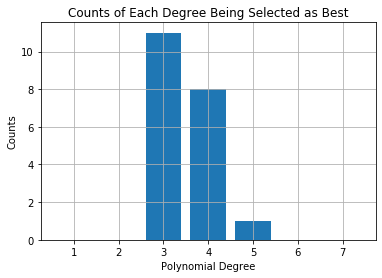

In [699]:
# Visualisation of picked results
# Bar Chart
print("Best d's over cross validations")
print(best_ds)
d_counts = np.zeros((len(d_range)))
unique, counts = np.unique(best_ds, return_counts = True)
d_counts[unique-1] = counts

plt.figure()
plt.title('Counts of Each Degree Being Selected as Best')
plt.bar(1 + np.arange(7), d_counts)
plt.xlabel('Polynomial Degree')
plt.ylabel('Counts')
plt.grid()

Best log10 C over cross validations
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


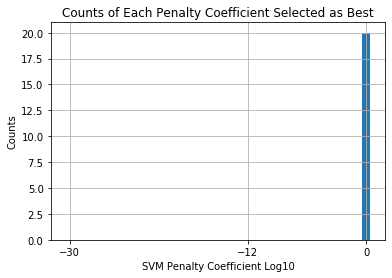

In [706]:
print("Best log10 C over cross validations")
print(coeff_pow)
coeff_counts = np.zeros((len(Cs)))
unique, counts = np.unique(coeff_pow, return_counts = True)
coeff_counts[np.where(np.log10(Cs) == unique)[0]] = counts

plt.figure()
plt.title('Counts of Each Penalty Coefficient Selected as Best')
plt.bar(np.log10(Cs), coeff_counts)
plt.xlabel('SVM Penalty Coefficient Log10')
plt.xticks(np.log10(Cs))
plt.ylabel('Counts')
plt.grid()

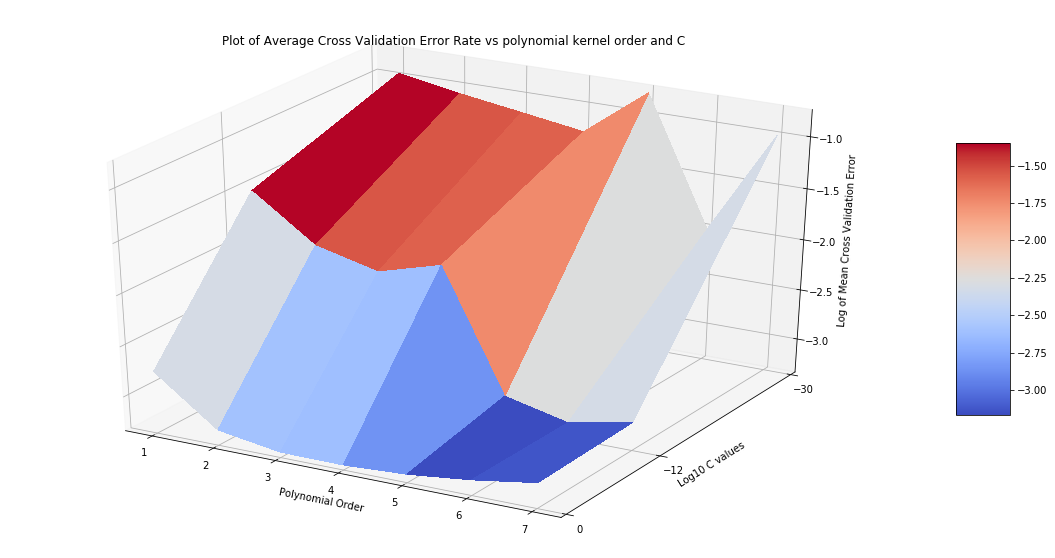

In [717]:
# Val Results
d_grid, C_powgrid = np.meshgrid(d_range,C_pow)
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
# ax.set_zlim(0, 30)
ax.set_xlabel("Polynomial Order")
ax.set_yticks(C_pow)
ax.set_ylim(0,-30)
ax.set_ylabel("Log10 C values")
ax.set_zlabel("Log of Mean Cross Validation Error")
ax.set_title("Plot of Average Cross Validation Error Rate vs polynomial kernel order and C")
MSE_surf = ax.plot_surface(d_grid, C_powgrid, np.log(av_val_error.T), cmap = cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(MSE_surf, shrink=0.5, aspect=5)

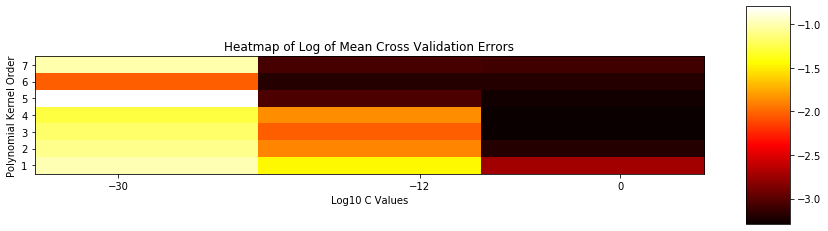

In [716]:
# Val Heatmap
fig = plt.figure(figsize = (15,8))
heat_map = plt.imshow(np.log(av_val_error), cmap="hot", origin="lower", 
           extent=[C_pow[0] - 5, C_pow[-1] + 5, d_range[0]-0.5, d_range[-1] + 0.5])
plt.xlabel("Log10 C Values")
plt.xticks(C_pow)
plt.yticks(d_range)
plt.ylabel("Polynomial Kernel Order")
plt.title("Heatmap of Log of Mean Cross Validation Errors")
fig.colorbar(heat_map, shrink=0.5, aspect=5)

## Gaussian Kernel

### 1) Basic Result

For gauss, from trials, found that reasonable are powers of 2, at powers -4, -6, .. ,-12

In [757]:
C = 1; coeff = 2**(-10)
train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = 8)
all_alphas, all_biases = fit_ovo_SVM_gauss(train_samples, train_labels, C, num_classes, coeff)        
# Predict
train_rate, train_preds = predictOvOGauss(train_samples, train_labels, train_samples, train_labels, all_alphas, all_biases, coeff)
test_rate, test_preds = predictOvOGauss(train_samples, train_labels, test_samples, test_labels, all_alphas, all_biases, coeff)

print(train_rate, test_rate)

All done in 12.434008121490479
0.04853455229900511 0.05860215053763441


In [718]:
Cs = [1 * 1e-30, 1 * 1e-12, 1]
# Cs = [1, 1e30]
pow_range = np.arange(-4, -14, -2)
num_classes = 10
num_iter = 20
results_train = np.zeros((len(pow_range), len(Cs),num_iter)); results_test = np.zeros((len(pow_range), len(Cs),num_iter))

start = time.time()
for it in range(num_iter):
    # For each iteration re-split. But NOT re-split for every d, lest it won't be a fair comparison
    start_iter = time.time()
    train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = it)
    print(f"Iteration {it+1}/{num_iter}")
    
    # Iterate through hyperparameters
    start_iter = time.time()
    for c_ind in range(len(Cs)):
        C = Cs[c_ind]; start_pow = time.time();
        for power_ind in range(len(pow_range)):
            coeff = 2 ** float(pow_range[power_ind])
            # Train svm, then predict on train and test
            all_alphas, all_biases = fit_ovo_SVM_gauss(train_samples, train_labels, C, num_classes, coeff)
            
            # Predict
            train_rate, train_preds = predictOvOGauss(train_samples, train_labels, train_samples, train_labels, all_alphas, all_biases, coeff)
            test_rate, test_preds = predictOvOGauss(train_samples, train_labels, test_samples, test_labels, all_alphas, all_biases, coeff)
            
            print(f"For c = {coeff}, C = {C}, train rate is {train_rate}, and test rate is {test_rate}")
            
            # Append results
            results_train[power_ind, c_ind, it] = train_rate; results_test[power_ind, c_ind, it] = test_rate
            
        print(f"All c's done in {time.time() - start_pow}")
    
    print(f"Iteration done in {time.time() - start_iter}")
    
print(f"{num_iter} iterations done in {time.time() - start}")

Iteration 1/20
All done in 35.611865520477295
For c = 0.0625, C = 1e-30, train rate is 0.016671148158107017, and test rate is 0.06344086021505377
All done in 34.0564603805542
For c = 0.015625, C = 1e-30, train rate is 0.19292820650712558, and test rate is 0.20053763440860214
All done in 34.04250645637512
For c = 0.00390625, C = 1e-30, train rate is 0.27198171551492334, and test rate is 0.27365591397849465
All done in 33.767611026763916
For c = 0.0009765625, C = 1e-30, train rate is 0.2929550954557677, and test rate is 0.2924731182795699
All done in 34.18936252593994
For c = 0.000244140625, C = 1e-30, train rate is 0.2975262167249261, and test rate is 0.2989247311827957
All c's done in 189.22307920455933
All done in 13.858956813812256
For c = 0.0625, C = 1e-12, train rate is 0.0014788921753159452, and test rate is 0.0521505376344086
All done in 13.929357528686523
For c = 0.015625, C = 1e-12, train rate is 0.08564130142511428, and test rate is 0.12419354838709677
All done in 14.334686279

All done in 14.149713516235352
For c = 0.0009765625, C = 1, train rate is 0.04598010217800484, and test rate is 0.06666666666666667
All done in 13.953466176986694
For c = 0.000244140625, C = 1, train rate is 0.07555794568432374, and test rate is 0.0913978494623656
All c's done in 88.70575046539307
Iteration done in 370.72993779182434
Iteration 5/20
All done in 34.96454358100891
For c = 0.0625, C = 1e-30, train rate is 0.016671148158107017, and test rate is 0.06129032258064516
All done in 35.53614568710327
For c = 0.015625, C = 1e-30, train rate is 0.1937348749663888, and test rate is 0.20376344086021506
All done in 34.43139410018921
For c = 0.00390625, C = 1e-30, train rate is 0.2760150578112396, and test rate is 0.26881720430107525
All done in 34.05547881126404
For c = 0.0009765625, C = 1e-30, train rate is 0.2980639956977682, and test rate is 0.28817204301075267
All done in 33.94085335731506
For c = 0.000244140625, C = 1e-30, train rate is 0.30317289593976876, and test rate is 0.2924

For c = 0.0625, C = 1, train rate is 0.012906695348211886, and test rate is 0.17258064516129032
All done in 13.937747716903687
For c = 0.015625, C = 1, train rate is 0.0014788921753159452, and test rate is 0.03118279569892473
All done in 14.51023244857788
For c = 0.00390625, C = 1, train rate is 0.021780048400107554, and test rate is 0.03494623655913978
All done in 13.925362586975098
For c = 0.0009765625, C = 1, train rate is 0.0458456574347943, and test rate is 0.0521505376344086
All done in 14.00456953048706
For c = 0.000244140625, C = 1, train rate is 0.07502016671148158, and test rate is 0.07473118279569893
All c's done in 88.63736391067505
Iteration done in 365.3877079486847
Iteration 9/20
All done in 34.61410164833069
For c = 0.0625, C = 1e-30, train rate is 0.01707448238773864, and test rate is 0.06881720430107527
All done in 34.4600145816803
For c = 0.015625, C = 1e-30, train rate is 0.19413820919602043, and test rate is 0.20376344086021506
All done in 34.578805923461914
For c 

All done in 14.19145154953003
For c = 0.0009765625, C = 1e-12, train rate is 0.20704490454423233, and test rate is 0.23387096774193547
All done in 14.485790967941284
For c = 0.000244140625, C = 1e-12, train rate is 0.2163215918257596, and test rate is 0.24731182795698925
All c's done in 88.36353850364685
All done in 14.064481019973755
For c = 0.0625, C = 1, train rate is 0.0014788921753159452, and test rate is 0.10967741935483871
All done in 14.093331575393677
For c = 0.015625, C = 1, train rate is 0.0018822264049475664, and test rate is 0.043010752688172046
All done in 14.31673789024353
For c = 0.00390625, C = 1, train rate is 0.024200053777897284, and test rate is 0.0489247311827957
All done in 13.96068549156189
For c = 0.0009765625, C = 1, train rate is 0.04544232320516268, and test rate is 0.06559139784946237
All done in 13.806073188781738
For c = 0.000244140625, C = 1, train rate is 0.07233127184727077, and test rate is 0.0913978494623656
All c's done in 87.97968935966492
Iteratio

All done in 13.841517686843872
For c = 0.015625, C = 1e-12, train rate is 0.09075020166711481, and test rate is 0.12204301075268817
All done in 14.177672147750854
For c = 0.00390625, C = 1e-12, train rate is 0.18082817961817693, and test rate is 0.17688172043010753
All done in 14.315802812576294
For c = 0.0009765625, C = 1e-12, train rate is 0.21376714170475936, and test rate is 0.20806451612903226
All done in 14.32721495628357
For c = 0.000244140625, C = 1e-12, train rate is 0.22331271847270773, and test rate is 0.22258064516129034
All c's done in 88.19081425666809
All done in 14.091619491577148
For c = 0.0625, C = 1, train rate is 0.0024200053777897286, and test rate is 0.17150537634408602
All done in 13.783549308776855
For c = 0.015625, C = 1, train rate is 0.002016671148158107, and test rate is 0.03225806451612903
All done in 14.753849744796753
For c = 0.00390625, C = 1, train rate is 0.021376714170475934, and test rate is 0.04086021505376344
All done in 14.334700345993042
For c = 

All done in 33.99852156639099
For c = 0.000244140625, C = 1e-30, train rate is 0.2979295509545577, and test rate is 0.3010752688172043
All c's done in 186.84652018547058
All done in 13.763728380203247
For c = 0.0625, C = 1e-12, train rate is 0.0012100026888948643, and test rate is 0.05806451612903226
All done in 13.931336402893066
For c = 0.015625, C = 1e-12, train rate is 0.08389351976337725, and test rate is 0.13225806451612904
All done in 14.015042304992676
For c = 0.00390625, C = 1e-12, train rate is 0.18943264318365152, and test rate is 0.20161290322580644
All done in 13.984716176986694
For c = 0.0009765625, C = 1e-12, train rate is 0.21712826028502286, and test rate is 0.221505376344086
All done in 14.72949504852295
For c = 0.000244140625, C = 1e-12, train rate is 0.21954826566281258, and test rate is 0.221505376344086
All c's done in 88.03421592712402
All done in 13.940590858459473
For c = 0.0625, C = 1, train rate is 0.005915568701263781, and test rate is 0.15
All done in 13.90

In [719]:
# Prints
res_train_mean = np.mean(results_train, axis = -1); res_test_mean = np.mean(results_test, axis = -1)
res_train_std = np.std(results_train, axis = -1); res_test_std = np.std(results_test, axis = -1)
for ls_idx in range(res_train_mean.shape[0]):
    for fs_idx in range(res_train_mean.shape[1]):
        power = pow_range[ls_idx]; C = Cs[fs_idx]
        print(f"For Gaussian Coeff of 2^{power} and C of {C}, average training error is {res_train_mean[ls_idx, fs_idx]} with std of {res_train_std[ls_idx, fs_idx]}")
        print(f"For Gaussian Coeff of 2^{power} and C of {C}, average test error is {res_test_mean[ls_idx, fs_idx]} with std of {res_test_std[ls_idx, fs_idx]}")

For Gaussian Coeff of 2^-4 and C of 1e-30, average training error is 0.01666442592094649 with std of 0.0010751167083639774
For Gaussian Coeff of 2^-4 and C of 1e-30, average test error is 0.0668010752688172 with std of 0.0053544581416779796
For Gaussian Coeff of 2^-4 and C of 1e-12, average training error is 0.0012637805861790805 with std of 0.0002056609107391551
For Gaussian Coeff of 2^-4 and C of 1e-12, average test error is 0.05338709677419355 with std of 0.004924860307270908
For Gaussian Coeff of 2^-4 and C of 1, average training error is 0.0025678945953213233 with std of 0.0030065464030149293
For Gaussian Coeff of 2^-4 and C of 1, average test error is 0.12368279569892474 with std of 0.023598093437276584
For Gaussian Coeff of 2^-6 and C of 1e-30, average training error is 0.1927399838666308 with std of 0.0020244539255397285
For Gaussian Coeff of 2^-6 and C of 1e-30, average test error is 0.2078494623655914 with std of 0.0057865049664833175
For Gaussian Coeff of 2^-6 and C of 1e-12

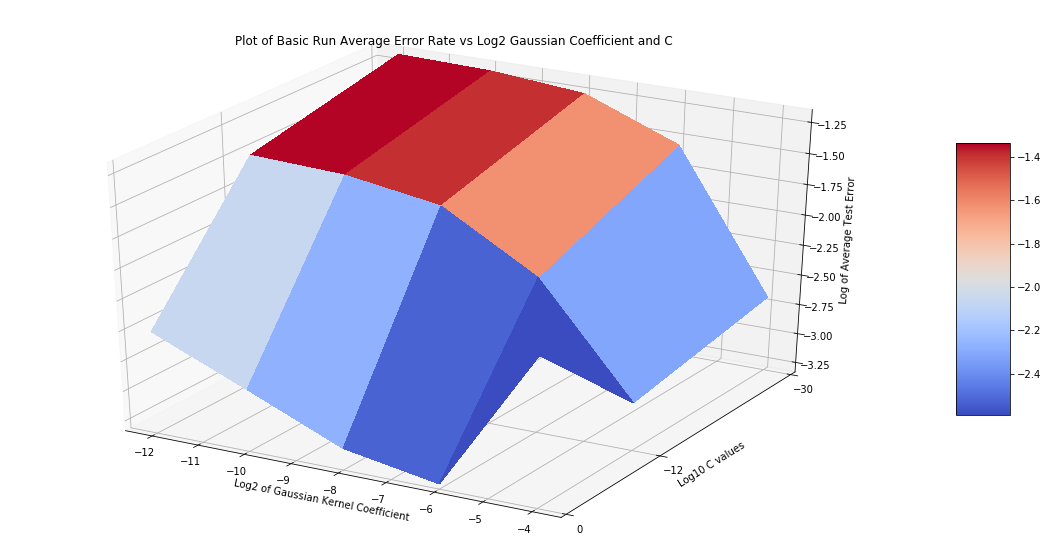

In [727]:
# Plot 
C_pow = np.log10(np.array(Cs)); 
# Test Results
pow_grid, C_powgrid = np.meshgrid(pow_range,C_pow)
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
# ax.set_zlim(0, 30)
ax.set_xlabel("Log2 of Gaussian Kernel Coefficient")
ax.set_yticks(C_pow)
ax.set_ylim(0,-30)
ax.set_ylabel("Log10 C values")
ax.set_zlabel("Log of Average Test Error")
ax.set_title("Plot of Basic Run Average Error Rate vs Log2 Gaussian Coefficient and C")
MSE_surf = ax.plot_surface(pow_grid, C_powgrid, np.log(res_test_mean.T), cmap = cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(MSE_surf, shrink=0.5, aspect=5)

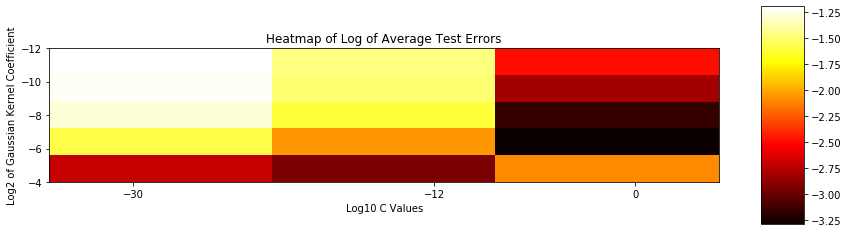

In [728]:
# Test Heatmap
fig = plt.figure(figsize = (15,8))
heat_map = plt.imshow(np.log(res_test_mean), cmap="hot", origin="lower", 
           extent=[C_pow[0]-5, C_pow[-1]+5, pow_range[0], pow_range[-1]])
plt.xlabel("Log10 C Values")
plt.xticks(C_pow)
plt.yticks(pow_range)
plt.ylabel("Log2 of Gaussian Kernel Coefficient")
plt.title("Heatmap of Log of Average Test Errors")
fig.colorbar(heat_map, shrink=0.5, aspect=5)

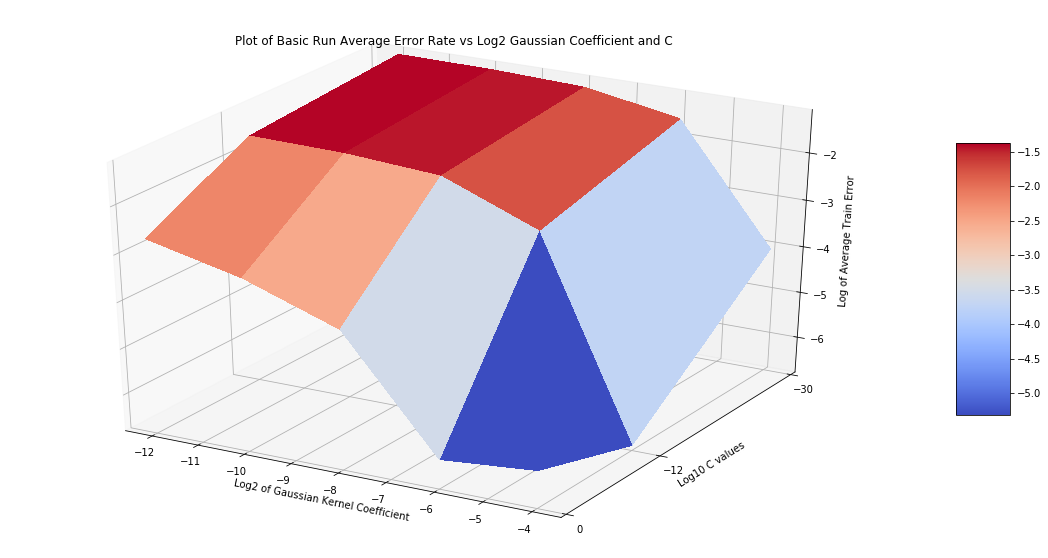

In [729]:
# Train Results
pow_grid, C_powgrid = np.meshgrid(pow_range,C_pow)
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
# ax.set_zlim(0, 30)
ax.set_xlabel("Log2 of Gaussian Kernel Coefficient")
ax.set_yticks(C_pow)
ax.set_ylim(0,-30)
ax.set_ylabel("Log10 C values")
ax.set_zlabel("Log of Average Train Error")
ax.set_title("Plot of Basic Run Average Error Rate vs Log2 Gaussian Coefficient and C")
MSE_surf = ax.plot_surface(pow_grid, C_powgrid, np.log(res_train_mean.T), cmap = cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(MSE_surf, shrink=0.5, aspect=5)

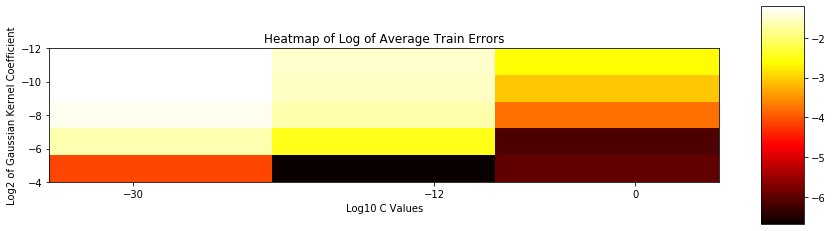

In [730]:
# Train Heatmap
fig = plt.figure(figsize = (15,8))
heat_map = plt.imshow(np.log(res_train_mean), cmap="hot", origin="lower", 
           extent=[-35, 5, pow_range[0], pow_range[-1]])
plt.xlabel("Log10 C Values")
plt.xticks(C_pow)
plt.ylabel("Log2 of Gaussian Kernel Coefficient")
plt.yticks(pow_range)
plt.title("Heatmap of Log of Average Train Errors")
fig.colorbar(heat_map, shrink=0.5, aspect=5)

### 2) Cross Validation

In [731]:
# Loop 20 times
pair_errors = []; best_pairs = []; # Contains 20 values, and 20 tuples of d,C
num_iter = 20
all_pair_errors = np.zeros((len(pow_range), len(Cs),num_iter)) # store results of validation error of all pairs over all 20 cross validation

for it in range(num_iter):
    # Do 1 Cross Validation, and iterate 20 times
    start_val = time.time()
    n = 5;
    
    # Split for every run
    train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = it)
    
    # Divide into sub-arrays
    x_train, y_train, sub_idxs = getSubArray(train_samples, train_labels.reshape(-1,1), n)
    
    # Convert to numpy arrays for ease of slicing
    x_train = np.array(x_train); y_train = np.array(y_train)
    
    # 1 5-fold cross validation starts here
    pairs_val_results = np.zeros((len(pow_range), len(Cs)))
    start_cv = time.time()
    for c_ind in range(len(Cs)):
        C = Cs[c_ind]; start_d = time.time()
        for power_ind in range(len(pow_range)):
            c = 2 ** float(pow_range[power_ind])
            # Loop through folds for a pair of hyperparameters
            val_indexes = np.arange(n); val_err = []
            start_folds = time.time()
            for val_idx in val_indexes:
                train_indexes = np.delete(val_indexes, val_idx)
                
                # Take one fold as val, rest becomes training
                val_samples = x_train[val_idx]; val_labels = y_train[val_idx].reshape(-1)
                
                # Training set
                train_mini_samples = catSubArrays(x_train[train_indexes])
                train_mini_labels = catSubArrays(y_train[train_indexes]).reshape(-1)
                
                # Train on training set, and then val
                all_alphas, all_biases = fit_ovo_SVM_gauss(train_mini_samples, train_mini_labels, C, num_classes, c)
                
                # Predict on val
                val_rate, val_preds = predictOvOGauss(train_mini_samples, train_mini_labels, val_samples, val_labels, all_alphas, all_biases, c)
                
                # Append Results
                val_err.append(val_rate) # this is result of each/5 fold for one pair
                
            # Store this pair's results
            print(f"Time for one 5-fold over a pair is {time.time() - start_folds}")
            print(f"For c = {c} and C = {C}, val error is {np.mean(val_err)}")
            pairs_val_results[power_ind, c_ind] = np.mean(np.array(val_err))
            all_pair_errors[power_ind, c_ind, it] = np.mean(np.array(val_err))
            
    # After done for all hyperparameters, re-train and re-evaluate on the best combination
    print(f"Time for one 5-fold over all pairs is {time.time() - start_cv}")
    [index_pow], [index_C] = np.where(pairs_val_results == np.min(pairs_val_results))
    best_pow, best_C = pow_range[index_pow], Cs[index_C]
    best_c = 2 ** float(best_pow)
    
    print(f"For iteration {it+1}, best c is {2 ** float(best_pow)} and best C is {best_C}")
    
    # Re-train
    all_alphas, all_biases = fit_ovo_SVM_gauss(train_samples, train_labels, best_C, num_classes, best_c)
    
    # And predict
    test_rate, test_preds = predictOvOGauss(train_samples, train_labels, test_samples, test_labels, all_alphas, all_biases, best_c)
    
    # Append results of this round of cross-validation
    pair_errors.append(test_rate); best_pairs.append([best_pow, best_C])
    
    print(f"Time for 1 cross validation is {time.time() - start_cv}")

All done in 21.789724588394165
All done in 21.499725818634033
All done in 23.520830869674683
All done in 21.291554927825928
All done in 21.72170114517212
Time for one 5-fold over a pair is 111.82302474975586
For c = 0.0625 and C = 1e-30, val error is 0.07098771792813705
All done in 22.95100164413452
All done in 22.33881402015686
All done in 23.256494283676147
All done in 22.20967149734497
All done in 22.090556859970093
Time for one 5-fold over a pair is 115.0436360836029
For c = 0.015625 and C = 1e-30, val error is 0.2050314192536029
All done in 23.30864381790161
All done in 21.841017484664917
All done in 23.958883047103882
All done in 22.047487497329712
All done in 22.758821487426758
Time for one 5-fold over a pair is 116.11777091026306
For c = 0.00390625 and C = 1e-30, val error is 0.2770933213296599
All done in 22.283098220825195
All done in 22.71795654296875
All done in 22.56269359588623
All done in 21.52741527557373
All done in 22.167191982269287
Time for one 5-fold over a pair is

All done in 12.76117992401123
Time for 1 cross validation is 1027.1094913482666
All done in 22.759719133377075
All done in 22.22367238998413
All done in 22.001420974731445
All done in 22.12332773208618
All done in 22.144408464431763
Time for one 5-fold over a pair is 113.2883529663086
For c = 0.0625 and C = 1e-30, val error is 0.07098780831724408
All done in 22.753042697906494
All done in 22.0496883392334
All done in 21.962080478668213
All done in 22.016857147216797
All done in 21.875874757766724
Time for one 5-fold over a pair is 112.78976106643677
For c = 0.015625 and C = 1e-30, val error is 0.20462584333036857
All done in 22.725417852401733
All done in 22.10622525215149
All done in 21.885088205337524
All done in 22.216487884521484
All done in 22.2986478805542
Time for one 5-fold over a pair is 113.28232884407043
For c = 0.00390625 and C = 1e-30, val error is 0.27574552935476637
All done in 23.111263513565063
All done in 22.21703863143921
All done in 21.9720356464386
All done in 22.1

All done in 8.30218243598938
Time for one 5-fold over a pair is 44.56157469749451
For c = 0.000244140625 and C = 1, val error is 0.08967593697348346
Time for one 5-fold over all pairs is 1014.5382845401764
For iteration 4, best c is 0.015625 and best C is 1
All done in 12.69258999824524
Time for 1 cross validation is 1027.851214647293
All done in 21.74242901802063
All done in 21.6209876537323
All done in 21.83151125907898
All done in 21.798195838928223
All done in 22.87723398208618
Time for one 5-fold over a pair is 111.9925889968872
For c = 0.0625 and C = 1e-30, val error is 0.07259917492823105
All done in 22.57203698158264
All done in 21.886663675308228
All done in 22.029690504074097
All done in 22.22459888458252
All done in 22.440086126327515
Time for one 5-fold over a pair is 113.22343802452087
For c = 0.015625 and C = 1e-30, val error is 0.20811838803682092
All done in 22.430480003356934
All done in 21.7918119430542
All done in 22.14224123954773
All done in 25.203875064849854
All 

Time for one 5-fold over a pair is 46.093825817108154
For c = 0.0009765625 and C = 1, val error is 0.06372685134969015
All done in 8.753604173660278
All done in 8.912243366241455
All done in 8.756595849990845
All done in 8.80446720123291
All done in 8.754600524902344
Time for one 5-fold over a pair is 46.23349118232727
For c = 0.000244140625 and C = 1, val error is 0.08859795648306831
Time for one 5-fold over all pairs is 1077.1382937431335
For iteration 6, best c is 0.015625 and best C is 1
All done in 13.48100209236145
Time for 1 cross validation is 1091.3373787403107
All done in 22.68254828453064
All done in 22.200732231140137
All done in 23.093372344970703
All done in 22.488436937332153
All done in 23.11962056159973
Time for one 5-fold over a pair is 115.78671431541443
For c = 0.0625 and C = 1e-30, val error is 0.06977650389396273
All done in 22.311400413513184
All done in 22.529743194580078
All done in 23.188257932662964
All done in 22.477001428604126
All done in 22.21094989776611

Time for one 5-fold over a pair is 48.866538763046265
For c = 0.00390625 and C = 1, val error is 0.047056207562314246
All done in 9.683118343353271
All done in 9.926175117492676
All done in 9.897350311279297
All done in 9.984978199005127
All done in 9.315535306930542
Time for one 5-fold over a pair is 51.24639678001404
For c = 0.0009765625 and C = 1, val error is 0.06601297264464065
All done in 10.23263144493103
All done in 9.540358781814575
All done in 9.256028652191162
All done in 9.15109920501709
All done in 9.331934690475464
Time for one 5-fold over a pair is 50.315874099731445
For c = 0.000244140625 and C = 1, val error is 0.09182502838217961
Time for one 5-fold over all pairs is 1061.238867521286
For iteration 8, best c is 0.015625 and best C is 1
All done in 13.537225484848022
Time for 1 cross validation is 1075.4769020080566
All done in 23.828991413116455
All done in 24.455066204071045
All done in 24.593133211135864
All done in 23.87212061882019
All done in 24.12023401260376
Ti

Time for one 5-fold over a pair is 46.08035659790039
For c = 0.015625 and C = 1, val error is 0.04302376871958406
All done in 9.01091456413269
All done in 9.2782142162323
All done in 9.001972198486328
All done in 9.10866641998291
All done in 9.135621070861816
Time for one 5-fold over a pair is 47.71549034118652
For c = 0.00390625 and C = 1, val error is 0.044770899769327
All done in 8.710224628448486
All done in 8.498284816741943
All done in 9.48985767364502
All done in 9.252274990081787
All done in 8.569096565246582
Time for one 5-fold over a pair is 46.796656370162964
For c = 0.0009765625 and C = 1, val error is 0.0630558930082218
All done in 8.675596714019775
All done in 8.907230138778687
All done in 8.65885615348816
All done in 8.653869867324829
All done in 8.791499614715576
Time for one 5-fold over a pair is 45.946977853775024
For c = 0.000244140625 and C = 1, val error is 0.09115497393178154
Time for one 5-fold over all pairs is 1045.9333717823029
For iteration 10, best c is 0.01

Time for one 5-fold over a pair is 49.3406503200531
For c = 0.0625 and C = 1, val error is 0.143457184487783
All done in 8.806463956832886
All done in 9.171992063522339
All done in 9.109652996063232
All done in 9.079303503036499
All done in 9.0852210521698
Time for one 5-fold over a pair is 47.55046248435974
For c = 0.015625 and C = 1, val error is 0.04046593776890759
All done in 9.189439058303833
All done in 9.445805072784424
All done in 9.614320039749146
All done in 9.238314628601074
All done in 9.548492670059204
Time for one 5-fold over a pair is 49.2703697681427
For c = 0.00390625 and C = 1, val error is 0.047459252590551816
All done in 8.797866344451904
All done in 8.79259443283081
All done in 8.742632389068604
All done in 8.73664903640747
All done in 8.759666681289673
Time for one 5-fold over a pair is 46.04050588607788
For c = 0.0009765625 and C = 1, val error is 0.05888642427923726
All done in 8.584056377410889
All done in 8.772734642028809
All done in 8.972986221313477
All don

Time for one 5-fold over a pair is 50.42578053474426
For c = 0.000244140625 and C = 1e-12, val error is 0.22653932649268568
All done in 9.318610906600952
All done in 9.342642068862915
All done in 9.718201637268066
All done in 9.314878702163696
All done in 9.720209836959839
Time for one 5-fold over a pair is 49.75469779968262
For c = 0.0625 and C = 1, val error is 0.13148912438264243
All done in 9.351237058639526
All done in 9.031095504760742
All done in 9.099979639053345
All done in 9.371094942092896
All done in 9.389952421188354
Time for one 5-fold over a pair is 48.66327166557312
For c = 0.015625 and C = 1, val error is 0.03885439037970655
All done in 10.197044134140015
All done in 9.676551103591919
All done in 9.608618259429932
All done in 9.809030055999756
All done in 9.651191234588623
Time for one 5-fold over a pair is 51.36105680465698
For c = 0.00390625 and C = 1, val error is 0.040737014700884366
All done in 9.187976598739624
All done in 9.053029775619507
All done in 9.26191949

All done in 10.026917219161987
All done in 10.222010612487793
All done in 9.547481298446655
All done in 9.434815168380737
All done in 9.707040548324585
Time for one 5-fold over a pair is 51.40065050125122
For c = 0.000244140625 and C = 1e-12, val error is 0.23379820451077798
All done in 9.100671529769897
All done in 9.269225358963013
All done in 9.17447829246521
All done in 9.576404094696045
All done in 9.393412828445435
Time for one 5-fold over a pair is 48.885854721069336
For c = 0.0625 and C = 1, val error is 0.15219175506721333
All done in 8.983989477157593
All done in 8.982011079788208
All done in 9.299144744873047
All done in 9.171489000320435
All done in 9.243292570114136
Time for one 5-fold over a pair is 47.936997175216675
For c = 0.015625 and C = 1, val error is 0.04167660946843974
All done in 9.072750568389893
All done in 9.470195770263672
All done in 9.779892683029175
All done in 9.340065479278564
All done in 9.580007553100586
Time for one 5-fold over a pair is 49.606592655

All done in 9.134634017944336
All done in 9.099678993225098
All done in 8.968405723571777
All done in 9.276207208633423
Time for one 5-fold over a pair is 48.09899091720581
For c = 0.0009765625 and C = 1e-12, val error is 0.22492479626295275
All done in 9.301140546798706
All done in 9.311146974563599
All done in 9.653198480606079
All done in 9.637371063232422
All done in 10.2476224899292
Time for one 5-fold over a pair is 50.60491704940796
For c = 0.000244140625 and C = 1e-12, val error is 0.23272257413714556
All done in 9.046257972717285
All done in 9.373189687728882
All done in 9.626437902450562
All done in 9.447747945785522
All done in 9.382451057434082
Time for one 5-fold over a pair is 49.15698719024658
For c = 0.0625 and C = 1, val error is 0.12355675712808498
All done in 9.054799795150757
All done in 9.199363231658936
All done in 9.190978288650513
All done in 9.102675199508667
All done in 8.874563694000244
Time for one 5-fold over a pair is 47.812987089157104
For c = 0.015625 an

All done in 9.277709245681763
All done in 9.230329275131226
All done in 9.14715027809143
Time for one 5-fold over a pair is 48.444642782211304
For c = 0.00390625 and C = 1e-12, val error is 0.19816817435697193
All done in 9.240302324295044
All done in 9.049848794937134
All done in 9.091750383377075
All done in 9.329032182693481
All done in 9.433292865753174
Time for one 5-fold over a pair is 48.422173500061035
For c = 0.0009765625 and C = 1e-12, val error is 0.22344440346804925
All done in 9.237815856933594
All done in 9.165502548217773
All done in 9.245794534683228
All done in 9.442761659622192
All done in 9.306154489517212
Time for one 5-fold over a pair is 48.72882843017578
For c = 0.000244140625 and C = 1e-12, val error is 0.23178162353298476
All done in 9.280205965042114
All done in 9.225341796875
All done in 9.329066038131714
All done in 9.160784006118774
All done in 8.864811182022095
Time for one 5-fold over a pair is 48.14809775352478
For c = 0.0625 and C = 1, val error is 0.15

Note: For SVM coeff C, and gauss coeff, it makes more sense to average the powers / power of the 10 instead of the actual value. Since we are trying in powers of 2, averaging the value would mislead because the larger powers would pull the average up. 

In [759]:
# Analyse Results

# Find mean and std of the best pairs
coeff_pow = np.array(best_pairs)[:, 0]; c_pow = np.log10(np.array(best_pairs)[:, 1])
coeff = 2 ** coeff_pow.astype(float); best_c = 10 ** c_pow.astype(float)

# average and std of gaussian coeff power and SVM penalty power
av_coeff_pow = np.mean(coeff_pow); std_coeff_pow = np.std(coeff_pow)
av_c_pow = np.mean(c_pow); std_c_pow = np.std(c_pow)

# average and std of gaussian coeff and SVM penalty
av_coeff = np.mean(coeff); std_coeff = np.std(coeff)
av_c = np.mean(best_c); std_c = np.std(best_c)

# average and mean error
av_test_error = np.mean(pair_errors); std_test_error = np.std(pair_errors)

print(f"For Gaussian Coefficient, mean and std of the power is {av_coeff_pow} and {std_coeff_pow}")
print(f"For SVM Penalty C, mean and std of the power is {av_c_pow} and {std_c_pow}")

print(f"For Gaussian Coefficient, mean and std is {av_coeff} and {std_coeff}")
print(f"For SVM Penalty C, mean and std is {av_c} and {std_c}")

print(f"Test errors mean is {av_test_error} with an std of {std_test_error}")

For Gaussian Coefficient, mean and std of the power is -6.2 and 0.6
For SVM Penalty C, mean and std of the power is 0.0 and 0.0
For Gaussian Coefficient, mean and std is 0.014453125 and 0.003515625
For SVM Penalty C, mean and std is 1.0 and 0.0
Test errors mean is 0.037741935483870975 with an std of 0.005423449553943437


Best c's over cross validations (Log2)
[-8 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -8 -6 -6]


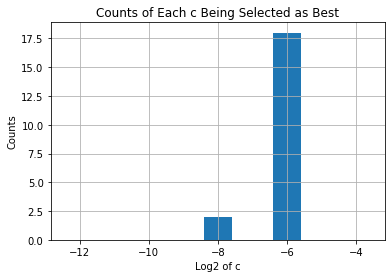

In [737]:
# Bar Chart
print("Best c's over cross validations (Log2)")
print(coeff_pow)
coeff_pow_counts = np.zeros((len(pow_range)))
unique, counts = np.unique(coeff_pow, return_counts = True)
for unique_pow_ind in range(len(unique)):
    unique_pow = unique[unique_pow_ind]
    loc = np.where(pow_range == unique_pow)[0]
    coeff_pow_counts[loc] = counts[unique_pow_ind]

plt.figure()
plt.title('Counts of Each c Being Selected as Best')
plt.bar(pow_range, coeff_pow_counts)
plt.xlabel('Log2 of c')
plt.ylabel('Counts')
plt.grid()

Best log10 C over cross validations
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


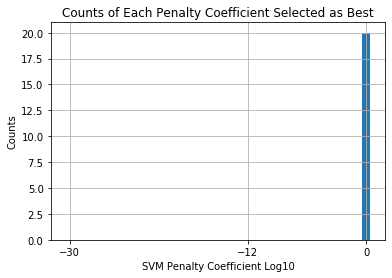

In [739]:
# Bar Chart
print("Best log10 C over cross validations")
print(c_pow)
c_counts = np.zeros((len(Cs)))
unique, counts = np.unique(c_pow, return_counts = True)
c_counts[np.where(np.log10(Cs) == unique)[0]] = counts

plt.figure()
plt.title('Counts of Each Penalty Coefficient Selected as Best')
plt.bar(np.log10(Cs), c_counts)
plt.xlabel('SVM Penalty Coefficient Log10')
plt.xticks(np.log10(Cs))
plt.ylabel('Counts')
plt.grid()

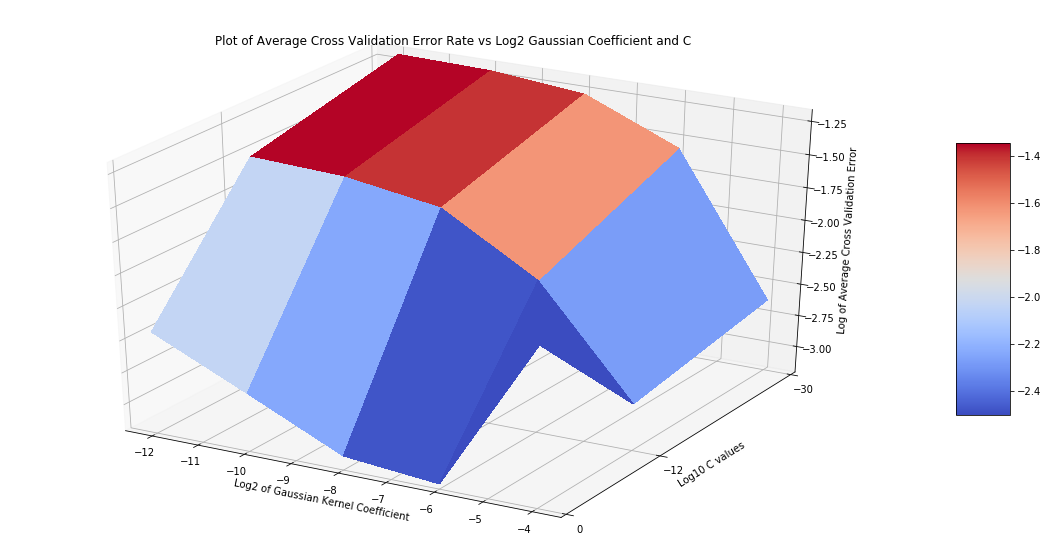

In [734]:
# Visualize mean validation error for all pairs
av_val_error = np.mean(all_pair_errors, axis = -1)
C_pow = np.log10(np.array(Cs))

# Test Results
pow_grid, C_powgrid = np.meshgrid(pow_range,C_pow)
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
ax.set_xlabel("Log2 of Gaussian Kernel Coefficient")
ax.set_yticks(C_pow)
ax.set_ylim(C_pow[-1],C_pow[0])
ax.set_ylabel("Log10 C values")
ax.set_zlabel("Log of Average Cross Validation Error")
ax.set_title("Plot of Average Cross Validation Error Rate vs Log2 Gaussian Coefficient and C")
MSE_surf = ax.plot_surface(pow_grid, C_powgrid, np.log(av_val_error.T), cmap = cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(MSE_surf, shrink=0.5, aspect=5)

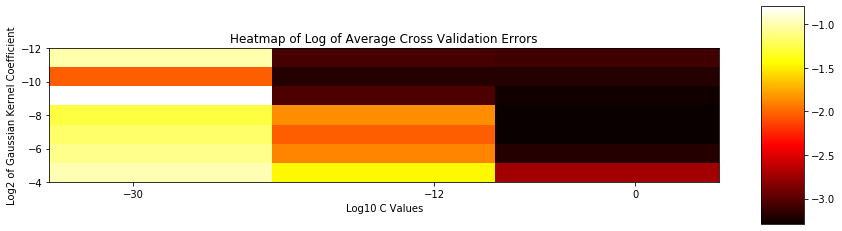

In [733]:
fig = plt.figure(figsize = (15,8))
heat_map = plt.imshow(np.log(av_val_error), cmap="hot", origin="lower", 
           extent=[-35, 5, pow_range[0], pow_range[-1]])
plt.xlabel("Log10 C Values")
plt.xticks(C_pow)
plt.ylabel("Log2 of Gaussian Kernel Coefficient")
plt.yticks(pow_range)
plt.title("Heatmap of Log of Average Cross Validation Errors")
fig.colorbar(heat_map, shrink=0.5, aspect=5)